In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
from scipy.io import loadmat
from cmocean import cm
import warnings
import netCDF4 as nc
from salishsea_tools import viz_tools, places, nc_tools
from salishsea_tools import visualisations as vis
import arrow
import glob
import pickle 
import skill_metrics as sm

#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11
warnings.simplefilter('ignore')
from salishsea_tools import nc_tools, viz_tools



In [3]:


def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)
            
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')
    
def plot_map(fig, ax, grid, T, tplt, w_map = [-127, -121, 47, 51.2], idepth=0):
    """Plot Strait of Georgia study area on Basemap object
    """
    bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

    #rivers
    cst = loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')
    # Plot Basemap
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 7])
    
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    #C = ax.contourf(x, y, T['vosaline'].isel(time_counter=23, deptht=idepth), range(21, 34), cmap=cm.haline, extend='both', zorder=.2)
    
    #dat = T['Bathymetry'].isel(time_counter=0, deptht=idepth)
    dat = T['Bathymetry'][:,:]
    C = ax.contourf(x, y, dat, levels=np.arange(0, 600, 10), cmap=cm.dense, extend = 'both') # extend='both', zorder=.2)

    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.0)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='DIC [μmol/kg]')
    #cbar.set_label(label='depth (m)', size=18)
    #cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), size=12)
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
    
    #ax.scatter(-123.43,49.04,s=650,c='darkorange',marker='o')
    # Define Significant Landmarks and Locations
    annotations = {
#        'Pacific\nOcean'     : {'text': [0.10, 0.250], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#        'British\nColumbia'  : {'text': [0.65, 0.850], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#        'Washington\nState'  : {'text': [0.70, 0.030], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#        'Strait of Georgia'  : {'text': [0.50, 0.575], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
#        'Juan de Fuca Strait': {'text': [0.36, 0.400], 'font': 13, 'rotate': -21, 'color': 'r', 'marker': None, 'arrow': None},
#         'Fraser River'       : {'text': [0.80, 0.90], 'font': 13, 'rotate':  0, 'color': 'r', 'marker': None, 'arrow': None},
#         'Puget\nSound'       : {'text': [0.60, 0.120], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#        '42'          : {'text': [0.68, 0.550], 'font': 14, 'rotate':   0, 'color': 'xkcd:red', 'marker': [-123.43, 49.04], 'markersize': 600, 'arrow': None},
#         '42'          : {'text': [0.68, 0.550], 'font': 14, 'rotate':   0, 'color': 'xkcd:red', 'marker': [-122.43, 49.04], 'markersize': 600, 'arrow': None},
#         '42'          : {'text': [0.68, 0.550], 'font': 14, 'rotate':   0, 'color': 'azure', 'marker': [-123.43, 49.04], 'markersize': 600, 'arrow': None},
        
#         'Victoria'           : {'text': [0.25, 0.39], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.37, 48.43], 'arrow': None},
#        'Seattle'            : {'text': [0.81, 0.230], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-122.33, 47.61], 'arrow': None},
    }
    
    
    # Timestamp
    ax.text(0.02, 0.01, ' ', transform=ax.transAxes, fontsize = 20)
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=7)
    
    # Plot Thalweg
    plot_thalweg(ax, x, y)    
    
    
#


### subplot examples references
https://www.machinelearningplus.com/plots/matplotlib-tutorial-complete-guide-python-plot-examples/

## code for calculating TA and DIC evaluation metrics metrics 

In [6]:
BR3_DIC_winter = pickle.load(open('./pkls/BR3_DIC_winter_mean.pkl', 'rb'))  
BR3_DIC_summer = pickle.load(open('./pkls/BR3_DIC_summer_mean.pkl', 'rb'))  
infil = np.loadtxt('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/DATASETS/grl2016_edit2.txt')
infil_cor = np.loadtxt('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/DATASETS/grl2016_nu.txt')
import seawater

crid= infil[:,0]
ln = infil[:,2]
stn = infil[:,3]
mon = infil[:,4]
day = infil[:,5]
lat_or = infil[:,6]
lon_or = infil[:,7]
lat = infil_cor[:,6]
lon = infil_cor[:,7]
P = infil[:,8]
T = infil[:,9]
S = infil[:,10]
S_nu = infil_cor[:,10]

w = S-S_nu
print(w)


ox = infil[:,11]
ox_qf = infil[:,12]
dic = infil[:,13]
dic_nu = infil_cor[:,13]
w = dic-dic_nu 
print(w)

alk = infil[:,15]
dic_qf = infil[:,14]
alk_qf = infil[:,16]
no3 = infil[:,17]
no3_qf = infil[:,18]
si = infil[:,19]
si_qf = infil[:, 20]
po4 = infil[:,21]
po4_qf = infil[:, 22]

dens = seawater.dens(S,T,P)
dic_conv=dic*dens/1000
TA_conv=alk*dens/1000

S_rs = S * 35.16504/35

##changeable variables
scrdir = '../KEY_MODEVAL/MODEL_EVAL_scripts/'

DIC13 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2013.nc')
TA13 = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_2013.nc')

DIC_mod13 = DIC13['model_output']['mod_point'][:]
is_ref = DIC13['model_output']['mod_x'][:]
js_ref = DIC13['model_output']['mod_y'][:]

TA_mod13 = TA13['model_output']['mod_point'][:]
is_ref2 = TA13['model_output']['mod_x'][:]
js_ref2 = TA13['model_output']['mod_y'][:]

DIC_mod13[DIC_mod13==0]=np.nan
#DIC,sal,TA
dic_compbl = dic_conv[~(np.isnan(DIC_mod13))]
DIC_mod13_compbl = DIC_mod13[~(np.isnan(DIC_mod13))]
TA_compbl = TA_conv[~(np.isnan(DIC_mod13))]
TA_mod13_compbl = TA_mod13[~(np.isnan(DIC_mod13))]

#
DIC14 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2014.nc')
TA14 = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_2014.nc')

DIC_mod14 = DIC14['model_output']['mod_point'][:]
is_ref = DIC14['model_output']['mod_x'][:]
js_ref = DIC14['model_output']['mod_y'][:]

TA_mod14 = TA14['model_output']['mod_point'][:]
is_ref2 = TA14['model_output']['mod_x'][:]
js_ref2 = TA14['model_output']['mod_y'][:]

DIC_mod14[DIC_mod14==0]=np.nan
#DIC,sal,TA
dic_compbl = dic_conv[~(np.isnan(DIC_mod14))]
DIC_mod14_compbl = DIC_mod14[~(np.isnan(DIC_mod14))]
TA_compbl = TA_conv[~(np.isnan(DIC_mod14))]
TA_mod14_compbl = TA_mod14[~(np.isnan(DIC_mod14))]

##changeable variables
DIC15 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2015.nc')
TA15 = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_2015.nc')

DIC_mod15 = DIC15['model_output']['mod_point'][:]
is_ref = DIC15['model_output']['mod_x'][:]
js_ref = DIC15['model_output']['mod_y'][:]

TA_mod15 = TA15['model_output']['mod_point'][:]
is_ref2 = TA15['model_output']['mod_x'][:]
js_ref2 = TA15['model_output']['mod_y'][:]


DIC_mod15[DIC_mod15==0]=np.nan
#DIC,sal,TA
dic_compbl = dic_conv[~(np.isnan(DIC_mod15))]
DIC_mod15_compbl = DIC_mod15[~(np.isnan(DIC_mod15))]
TA_compbl = TA_conv[~(np.isnan(DIC_mod15))]
TA_mod15_compbl = TA_mod15[~(np.isnan(DIC_mod15))]

DIC16 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2016.nc')
TA16 = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_2016.nc')

DIC_mod16 = DIC16['model_output']['mod_point'][:]
is_ref = DIC16['model_output']['mod_x'][:]
js_ref = DIC16['model_output']['mod_y'][:]

TA_mod16 = TA16['model_output']['mod_point'][:]
is_ref2 = TA16['model_output']['mod_x'][:]
js_ref2 = TA16['model_output']['mod_y'][:]

DIC_mod16[DIC_mod16==0]=np.nan
#DIC,sal,TA
dic_compbl = dic_conv[~(np.isnan(DIC_mod16))]
DIC_mod16_compbl = DIC_mod16[~(np.isnan(DIC_mod16))]
TA_compbl = TA_conv[~(np.isnan(DIC_mod16))]
TA_mod16_compbl = TA_mod16[~(np.isnan(DIC_mod16))]

DIC17 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2017.nc')
TA17 = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_2017.nc')

DIC_mod17 = DIC17['model_output']['mod_point'][:]
is_ref = DIC17['model_output']['mod_x'][:]
js_ref = DIC17['model_output']['mod_y'][:]

TA_mod17 = TA17['model_output']['mod_point'][:]
is_ref2 = TA17['model_output']['mod_x'][:]
js_ref2 = TA17['model_output']['mod_y'][:]

DIC_mod17[DIC_mod17==0]=np.nan
#DIC,sal,TA
dic_compbl = dic_conv[~(np.isnan(DIC_mod17))]
DIC_mod17_compbl = DIC_mod17[~(np.isnan(DIC_mod17))]
TA_compbl = TA_conv[~(np.isnan(DIC_mod17))]
TA_mod17_compbl = TA_mod17[~(np.isnan(DIC_mod17))]

taylor_statsDIC13 = sm.taylor_statistics(DIC_mod13_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')
taylor_statsDIC14 = sm.taylor_statistics(DIC_mod14_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')
taylor_statsDIC15 = sm.taylor_statistics(DIC_mod15_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')
taylor_statsDIC16 = sm.taylor_statistics(DIC_mod16_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')
taylor_statsDIC17 = sm.taylor_statistics(DIC_mod17_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')

# Store statistics in arrays
sdevDIC = np.array([taylor_statsDIC13['sdev'][0],
                 taylor_statsDIC13['sdev'][1],
                 taylor_statsDIC14['sdev'][1],
                 taylor_statsDIC15['sdev'][1],
                 taylor_statsDIC16['sdev'][1],
                 taylor_statsDIC17['sdev'][1]])

crmsdDIC = np.array([taylor_statsDIC13['crmsd'][1],
                 taylor_statsDIC13['crmsd'][1],
                 taylor_statsDIC14['crmsd'][1],
                 taylor_statsDIC15['crmsd'][1],
                 taylor_statsDIC16['crmsd'][1],
                 taylor_statsDIC17['crmsd'][1]])

ccoefDIC = np.array([taylor_statsDIC13['ccoef'][1],
                 taylor_statsDIC13['ccoef'][1],
                 taylor_statsDIC14['ccoef'][1],
                 taylor_statsDIC15['ccoef'][1],
                 taylor_statsDIC16['ccoef'][1],
                 taylor_statsDIC17['ccoef'][1]])

taylor_statsTA13 = sm.taylor_statistics(TA_mod13_compbl[~np.isnan(TA_compbl)],TA_compbl[~np.isnan(TA_compbl)],'data')
taylor_statsTA14 = sm.taylor_statistics(TA_mod14_compbl[~np.isnan(TA_compbl)],TA_compbl[~np.isnan(TA_compbl)],'data')
taylor_statsTA15 = sm.taylor_statistics(TA_mod15_compbl[~np.isnan(TA_compbl)],TA_compbl[~np.isnan(TA_compbl)],'data')
taylor_statsTA16 = sm.taylor_statistics(TA_mod16_compbl[~np.isnan(TA_compbl)],TA_compbl[~np.isnan(TA_compbl)],'data')
taylor_statsTA17 = sm.taylor_statistics(TA_mod17_compbl[~np.isnan(TA_compbl)],TA_compbl[~np.isnan(TA_compbl)],'data')

# Store statistics in arrays - using 
sdevTA = np.array([taylor_statsTA13['sdev'][0],
                 taylor_statsTA13['sdev'][1],
                 taylor_statsTA14['sdev'][1],
                 taylor_statsTA15['sdev'][1],
                 taylor_statsTA16['sdev'][1],
                 taylor_statsTA17['sdev'][1]])

crmsdTA = np.array([taylor_statsTA13['crmsd'][1],
                 taylor_statsTA13['crmsd'][1],
                 taylor_statsTA14['crmsd'][1],
                 taylor_statsTA15['crmsd'][1],
                 taylor_statsTA16['crmsd'][1],
                 taylor_statsTA17['crmsd'][1]])

ccoefTA = np.array([taylor_statsTA13['ccoef'][1],
                 taylor_statsTA13['ccoef'][1],
                 taylor_statsTA14['ccoef'][1],
                 taylor_statsTA15['ccoef'][1],
                 taylor_statsTA16['ccoef'][1],
                 taylor_statsTA17['ccoef'][1]])

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['nonden_obs','2013', '2014','2015','2016','2017'] #'M3']

#crmsd[0] = 0

target_statsDIC13 = sm.target_statistics(DIC_mod13_compbl,dic_compbl,'data')
target_statsDIC14 = sm.target_statistics(DIC_mod14_compbl,dic_compbl,'data')
target_statsDIC15 = sm.target_statistics(DIC_mod15_compbl,dic_compbl,'data')
target_statsDIC16 = sm.target_statistics(DIC_mod16_compbl,dic_compbl,'data')
target_statsDIC17 = sm.target_statistics(DIC_mod17_compbl,dic_compbl,'data')


bias = np.array([target_statsDIC13['bias'],
                 target_statsDIC14['bias'],
                 target_statsDIC15['bias'],
                 target_statsDIC16['bias'],
                 target_statsDIC17['bias']])

crmsd = np.array([target_statsDIC13['crmsd'],
                 target_statsDIC14['crmsd'],
                 target_statsDIC15['crmsd'],
                 target_statsDIC16['crmsd'],
                 target_statsDIC17['crmsd']])

rmsd = np.array([target_statsDIC13['rmsd'],
                 target_statsDIC14['rmsd'],
                 target_statsDIC15['rmsd'],
                 target_statsDIC16['rmsd'],
                 target_statsDIC17['rmsd']])

label2 = ['2013', '2014','2015','2016','2017']



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [5]:
BR3_DIC_summer = pickle.load(open('./pkls/BR3_DIC_summer_mean.pkl', 'rb'))
BR3_DIC_winter = pickle.load(open('./pkls/BR3_DIC_winter_mean.pkl', 'rb'))
tdat_p = BR3_DIC_summer[0,:,:]
            

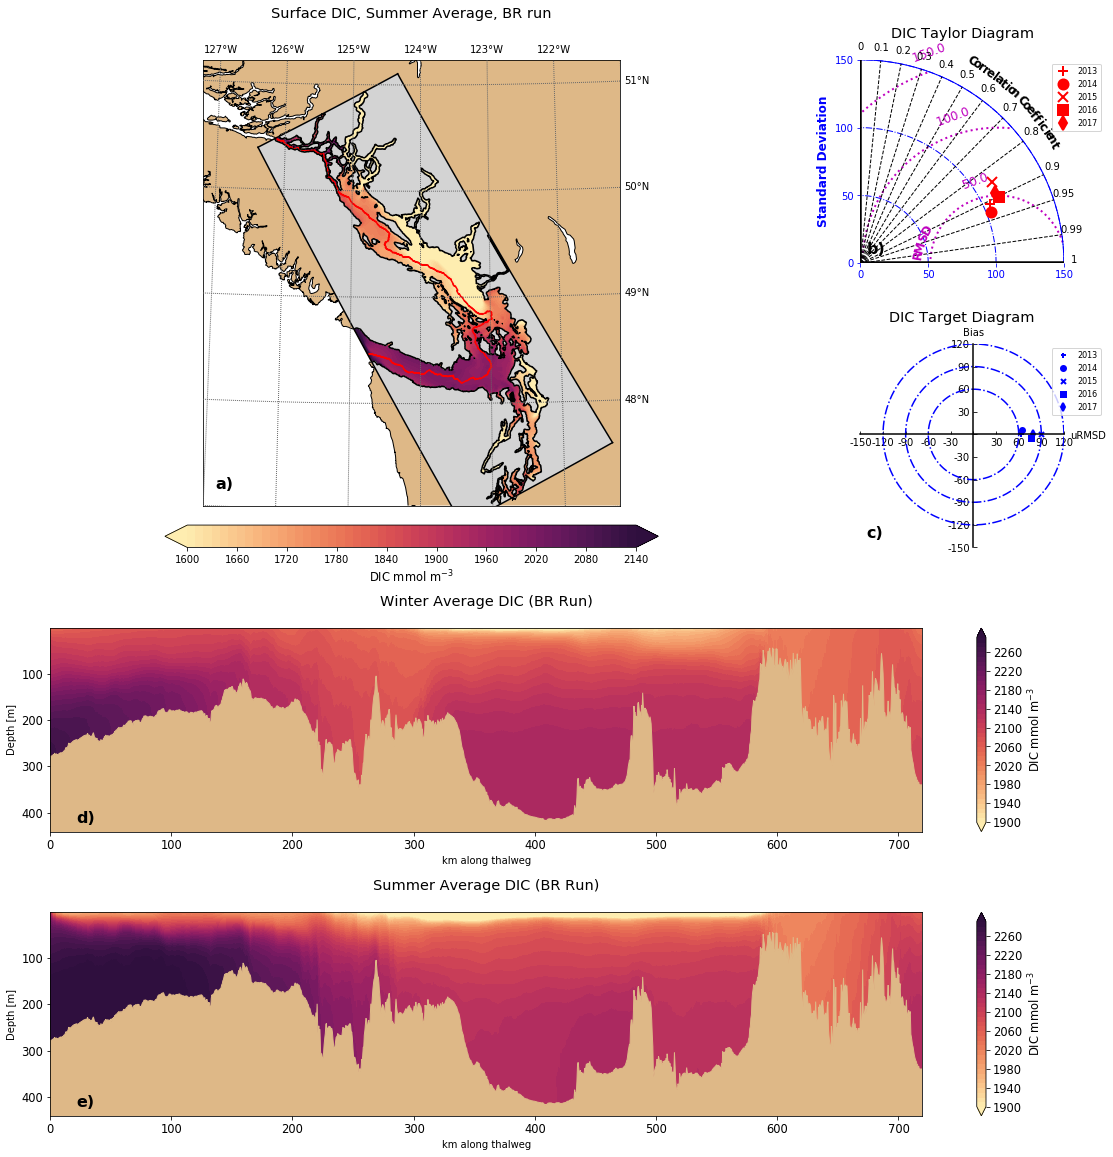

In [10]:
grid = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
dic_min = 1900
dic_max = 2300
dicstep = 10

fact = 1.4
fs = 11.5
mlt = 1
fig = plt.figure(figsize=(11.5*fact, 11.5*fact))

ax1 = plt.subplot2grid((4*mlt,3*mlt), (0,0), colspan=2*mlt, rowspan=2*mlt) # topleft

bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

#not plotting rivers for now
# Plot Basemap
w_map = [-127, -121, 47, 51.2]
m = plot_basemap(ax1, w_map, zorder=[0, 1, 7]) #offset=[-30000, -15000]
x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)  

mesh = ax1.contourf(x, y, tdat_p, levels=np.arange(1600, 2150, dicstep), \
                 cmap=cm.matter, extend = 'both') # extend='both', zorder=.2)

ax1.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
ax1.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)
ax1.set_title('Surface DIC, Summer Average, BR run',fontsize = fs+3, y=1.08)

cbar = fig.colorbar(mesh, ax=ax1, orientation = 'horizontal',fraction=0.046, pad=0.04)
cbar.set_label(label='DIC mmol m$^{-3}$', size=fs)
# # Colorbar
# fig.subplots_adjust(bottom=0.0)
# #cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
# cbar = fig.colorbar(C, cax=ax1, orientation='horizontal', label='DIC [μmol/kg]')
# #cbar.set_label(label='depth (m)', size=18)
# #cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), size=12)
# cbar.set_ticks(range(0, 550, 50))

# Box around model domain
ax1.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
ax1.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
ax1.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
ax1.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')

plot_thalweg(ax1, x, y)

ax2 = plt.subplot2grid((4*mlt,3*mlt), (0*mlt,2*mlt), rowspan=1*mlt) 
sm.taylor_diagram(sdevDIC,crmsdDIC,ccoefDIC, markerLabel = label,
                  markerLabelColor = 'r', 
                  markerColor = 'r', markerLegend = 'on', 
                  tickRMSangle = 110.0,
                  colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
                  titleRMS = 'on',  colSTD = 'b', styleSTD = '-.', 
                  widthSTD = 1.0, titleSTD = 'on', 
                  colCOR = 'k', styleCOR = '--', widthCOR = 1.0, 
                  titleCOR = 'on')
ax2.text(0.03, 0.03, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax2.set_title('DIC Taylor Diagram', fontsize = fs+3, y=1.08)

ax3 = plt.subplot2grid((4*mlt,3*mlt), (1*mlt,2*mlt), rowspan=1*mlt)
sm.target_diagram(bias,crmsd,rmsd, markerLabel = label2,
                  markerLabelColor = 'b',
                  markerColor = 'b', markerSize = '5', markerLegend = 'on',
                  ticks = np.arange(-150,150,30),
                  axismax = 150.0,
                  circles = [60, 90, 120],
                  circleLineSpec = 'b-.', circleLineWidth = 1.5)
ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax3.set_title('DIC Target Diagram', fontsize = fs+3, y=1.08)

ax4 = plt.subplot2grid((4*mlt,3*mlt), (2*mlt,0*mlt), colspan =3*mlt )  
bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
cbar = \
vis.contour_thalweg(ax4, BR3_DIC_winter, bathy, mesh,\
                    np.arange(dic_min, dic_max, dicstep), cmap = cm.matter)
ax4.set_title('Winter Average DIC (BR Run)',fontsize = fs+3, y=1.08)
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('DIC mmol m$^{-3}$', fontsize = fs)
ax4.tick_params(axis='both', which='major', labelsize=fs)
ax4.set_xlabel('km along thalweg')
ax4.text(0.03, 0.03, 'd)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='bottom')

ax5 = plt.subplot2grid((4*mlt,3*mlt), (3*mlt,0*mlt), colspan =3*mlt ) 
cbar = \
vis.contour_thalweg(ax5, BR3_DIC_summer, bathy, mesh,\
                    np.arange(dic_min, dic_max, dicstep), cmap = cm.matter)
ax5.set_title('Summer Average DIC (BR Run)',fontsize = fs+3, y=1.08)
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('DIC mmol m$^{-3}$', fontsize = fs)
ax5.tick_params(axis='both', which='major', labelsize=fs)
ax5.set_xlabel('km along thalweg')
ax5.text(0.03, 0.03, 'e)', transform=ax5.transAxes, fontsize=16, fontweight='bold', va='bottom')

fig.tight_layout()

 # code for calculating summer, winter DIC averages (commented out)

In [7]:
# #winter - dec 21 to march 19

# start ='2015-12-01'
# end ='2015-12-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_winter1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
#     BR_oma_winter1[i,:,:,:] = t_dic

# start ='2015-01-01'
# end ='2015-02-28'

# start_run = arrow.get(start)
# end_run = arrow.get(end)
# arrow_array2 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array2.append(r)
# dayslen = len(arrow_array2)

# BR_oma_winter2 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array2[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
#     BR_oma_winter2[i,:,:,:] = t_dic


# BR_oma_winter = np.concatenate((BR_oma_winter1,BR_oma_winter2),axis=0)
# print(np.shape(BR_oma_winter))
# BR_oma_winter_mean = np.nanmean(BR_oma_winter,axis=0)
# pickle.dump(BR_oma_winter_mean, open("./pkls/BR3_DIC_winter_mean.pkl", 'wb'))

#summer - dec 21 to march 19

# start ='2015-06-01'
# end ='2015-08-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_summer1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
#     BR_oma_summer1[i,:,:,:] = t_dic


# print(np.shape(BR_oma_summer1))
# BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
# pickle.dump(BR_oma_summer_mean, open("./pkls/BR3_DIC_summer_mean.pkl", 'wb'))


# code for using plotmap (just in case)

In [8]:
# grid_NEMO = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
# T_NEMO = xr.open_dataset('/data/tjarniko/results/BASERUN_EXP/PILA3_rerun/LA3/ncs/SKOG_1d_20151127_20151231_ptrc_T_20151231-20151231.nc')
# bathy = grid_NEMO['Bathymetry'][:]
# tplt = bathy
# # Plot Model Domain
# fig, ax = plt.subplots(1, 1, figsize=(10, 12.5))
# plot_map(fig, ax, grid_NEMO, grid_NEMO, tplt, w_map = [-127, -121, 47, 51.2], idepth=0)


In [9]:
print(grid)

<xarray.Dataset>
Dimensions:     (x: 398, y: 898)
Dimensions without coordinates: x, y
Data variables:
    nav_lon     (y, x) float64 -123.4 -123.4 -123.4 ... -124.4 -124.3 -124.3
    nav_lat     (y, x) float64 46.86 46.86 46.86 46.87 ... 51.1 51.1 51.1 51.1
    Bathymetry  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Bathymetry 201702
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       https://bitbucket.org/salishsea/tools/src/tip/ProcessNewRiv...
    references:   NEMO-forcing/grid/bathymetry_201702.nc
    history:      [2017-09-30 12:34:48] Created netCDF4 zlib=True dataset.
    comment:      Bathymetry processed from Michaels New Full River Bathymetr...
